In [1]:
import re
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import json
from pylab import *
import pandas as pd
from dogues_functions_2 import clean_article_name, plot_category_trends, fetch_pageview_count, normal_data, extract_clean_text, fetch_and_combine_pageview_data, scrape_wikipedia_sub_subheadings_with_links, fetch_pageview_count_dates, fetch_viewcount_df


# Loading the data from milestone 2 

In [3]:
#load data into df
df_fakecovidNews = pd.read_csv('./Data/covid-19_misinformation5.csv')

In [233]:

def getSubLinksFromIntro(website):
    link = "https://en.wikipedia.org/wiki/"+website

    #load online the html file 
    r = requests.get(link)
    soup = BeautifulSoup(r.text, 'html.parser')

    intro = soup.find_all('div', attrs={'class':'mw-content-ltr mw-parser-output'})[0].find_all('p')[2]
    #get the all the href
    links = intro.find_all('a', href=True)
    #make it into a list
    links = [link['href'] for link in links]

    return links


  
def existed(article, dateMin="2020-03-01"):
    #check if the first timestamp is less dateMin 
    if pd.Timestamp(article.iloc[0]['timestamp']) <= pd.Timestamp(dateMin):
        return True
    else:
        return False  


def getSubLinksFromIntroPablo(links):
    views = []
    for link in links:
        result = fetch_pageview_count("en", link)
        if(len(result) != 0):
            views.append(result)

    return views[0]


def standarization(array):
    return (array - np.mean(array)) / np.std(array)

def minMax(array):
    return (array - np.min(array)) / (np.max(array) - np.min(array))

def nonefunction(array):
    return array



In [210]:
class wikiTopic:
    df = []

    links = []
    dfView = []
    dfViewFinal = []

    dfSubLinks = []
    dfViewSubLinks = []
    dfViewSubLinksFinal = []

    def __init__(self, df, index):
        self.df = df.iloc[index]

        self.extractLinksFromDf(df, index)
        self.getViews()

        self.getSublinks()
        self.getViewsSubLinks()

    def extractLinksFromDf(self,df, index):
        #extract links from df
        links = df['Links'][index]
        #split links by commas
        links = links.split(',')
        #remove brackets and quotes
        self.links = [re.sub(r'[\[\]\'\s]', '', link) for link in links]
        #replace "/wiki/" with nothing
        self.links = [re.sub(r'/wiki/', '', link) for link in self.links]
        #remove empty strings
        self.links = [link for link in self.links if link != '']

    def getViews(self):
        #fetch view counts
        print(self.links)
        viewsdf = fetch_pageview_count("en", self.links)
        keys = list(viewsdf.keys())
        #make a list of df 
        for i in range(len(keys)):
            if(existed(viewsdf[keys[i]])):
                self.dfViewFinal.append(viewsdf[keys[i]])
            self.dfView.append(viewsdf[keys[i]])

    def getSublinks(self):
        for i in range(len(self.links)):
            allSublinks = getSubLinksFromIntro(self.links[i])
            allSublinks = [re.sub(r'/wiki/', '', link) for link in allSublinks]
            #if the sublinks have "#cite_" remove them 
            allSublinks = [link for link in allSublinks if "#cite_" not in link]
            self.dfSubLinks.append(allSublinks)

    def getViewsSubLinks(self):
        #fetch view counts
        viewsdf = getSubLinksFromIntroPablo(self.dfSubLinks)
        keys = list(viewsdf.keys())
        #make a list of df 
        for i in range(len(keys)):
            if(existed(viewsdf[keys[i]])):
                self.dfViewSubLinksFinal.append(viewsdf[keys[i]])
            self.dfViewSubLinks.append(viewsdf[keys[i]])

    



In [261]:
#make subplot of all the views of dfViewFinal
def plotAllInfos(topic, function):

    fig, axs = plt.subplots(len(topic.dfViewFinal)//3, 3, figsize=(15, len(topic.dfViewFinal)), sharex=True)
    for i in range(len(topic.dfViewFinal)):
        plt.xticks(rotation=45)
        axs[i//3, i%3].plot(topic.dfViewFinal[i]['timestamp'], function(topic.dfViewFinal[i]['views']))
        axs[i//3, i%3].set_title(topic.dfViewFinal[i]['article'].unique()[0])

        #axs[i].set_title(topic.dfViewFinal[i]['article'])
        #make rotation of x axis
        axs[i//3, i%3].set_ylabel('Views')
        axs[i//3, i%3].set_xlabel('Date')


    #make subplot of all the views of dfViewSubLinksFinal
    fig, axs = plt.subplots(len(topic.dfViewSubLinksFinal)//3+1, 3, figsize=(15, len(topic.dfViewSubLinksFinal)), sharex=True)
    for i in range(len(topic.dfViewSubLinksFinal)):
        plt.xticks(rotation=45)
        axs[i//3, i%3].plot(topic.dfViewSubLinksFinal[i]['timestamp'], function(topic.dfViewSubLinksFinal[i]['views']))
        axs[i//3, i%3].set_title(topic.dfViewSubLinksFinal[i]['article'].unique()[0])
        #axs[i].set_title(topic.dfViewFinal[i]['article'])
        #make rotation of x axis
        axs[i//3, i%3].set_ylabel('Views')
        axs[i//3, i%3].set_xlabel('Date')

In [240]:
topic = wikiTopic(df_fakecovidNews, 1)

['Israeli_secret_service', 'The_Washington_Times', 'Biosafety_level_4', 'Wuhan_Institute_of_Virology', 'Li-Meng_Yan', 'Preprint', 'Steve_Bannon', 'Guo_Wengui', 'Expatriate', 'Anti-Chinese_sentiment', 'Echo_chamber_(media)', 'Plandemic', 'The_Epoch_Times', 'Chinese_Communist_Party', 'Falun_Gong', 'Misinformation_related_to_the_COVID-19_pandemic#Misinformation_regarding_virus_origin', 'Severe_acute_respiratory_syndrome_coronavirus_2', 'Chinese_Communist_Party', 'Fort_Detrick', 'Andrew_Bridgen']
Error fetching data for Misinformation_related_to_the_COVID-19_pandemic#Misinformation_regarding_virus_origin. Status Code: 404


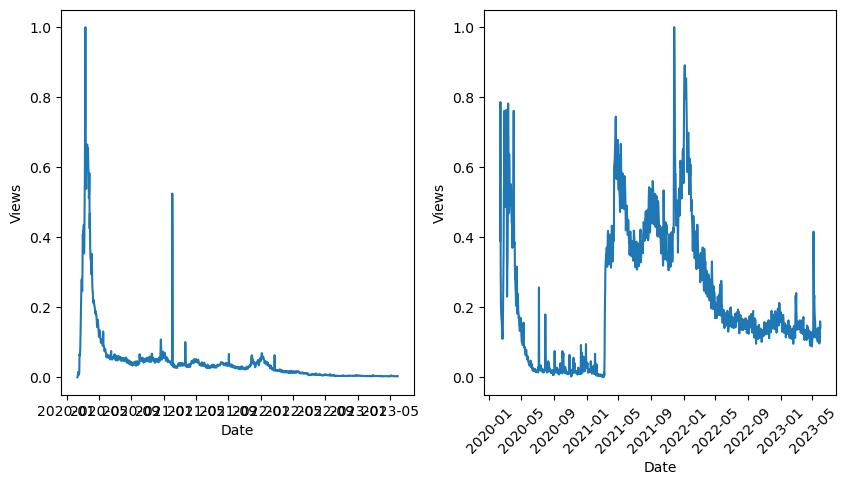

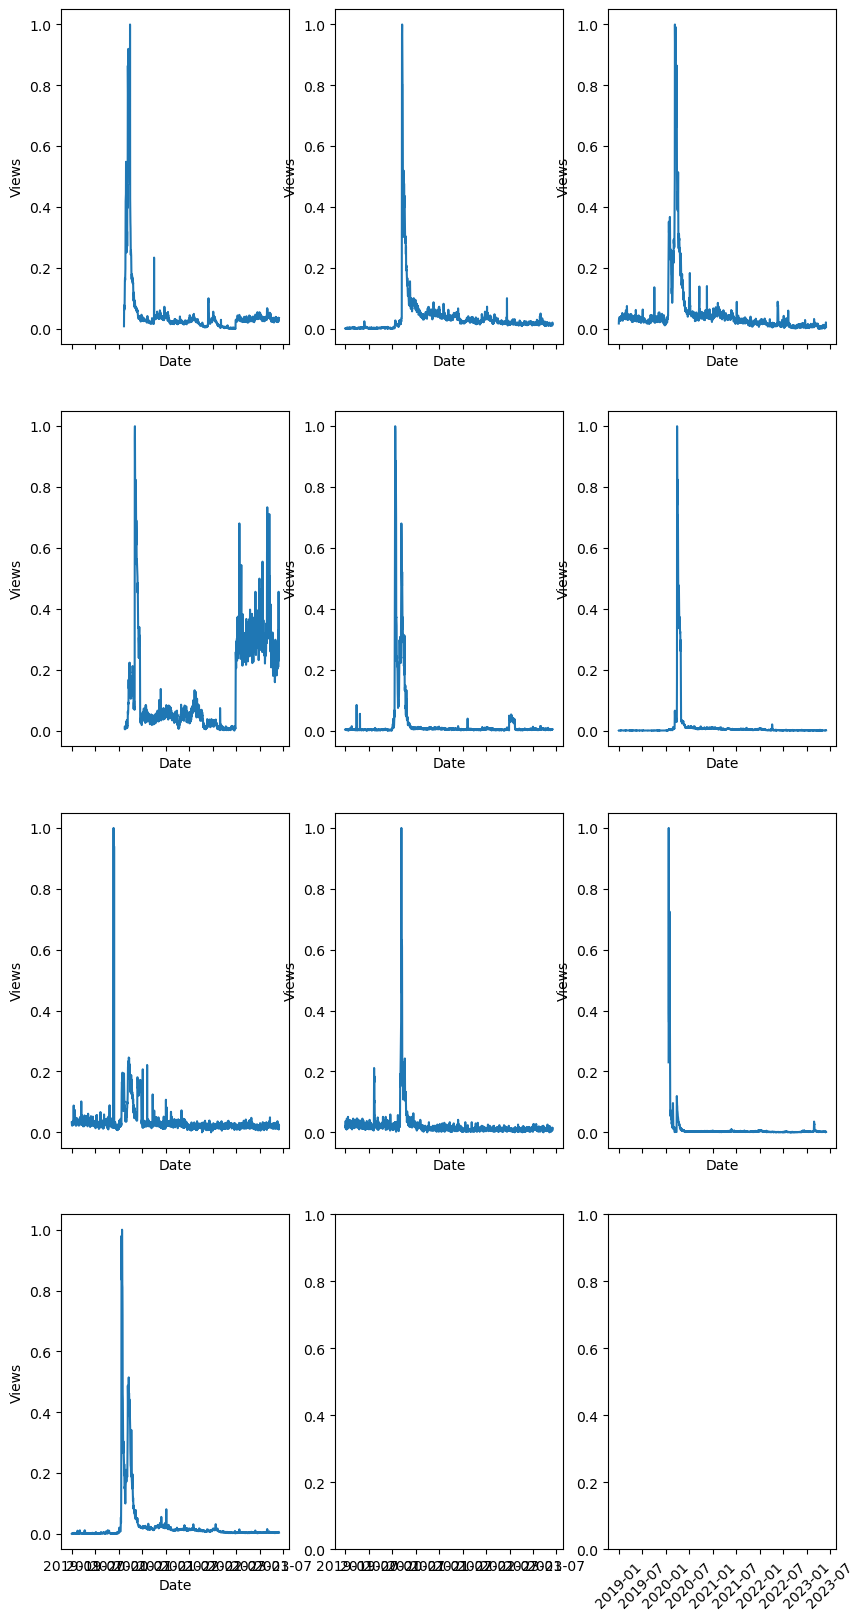

In [239]:
plotAllInfos(topic, minMax)

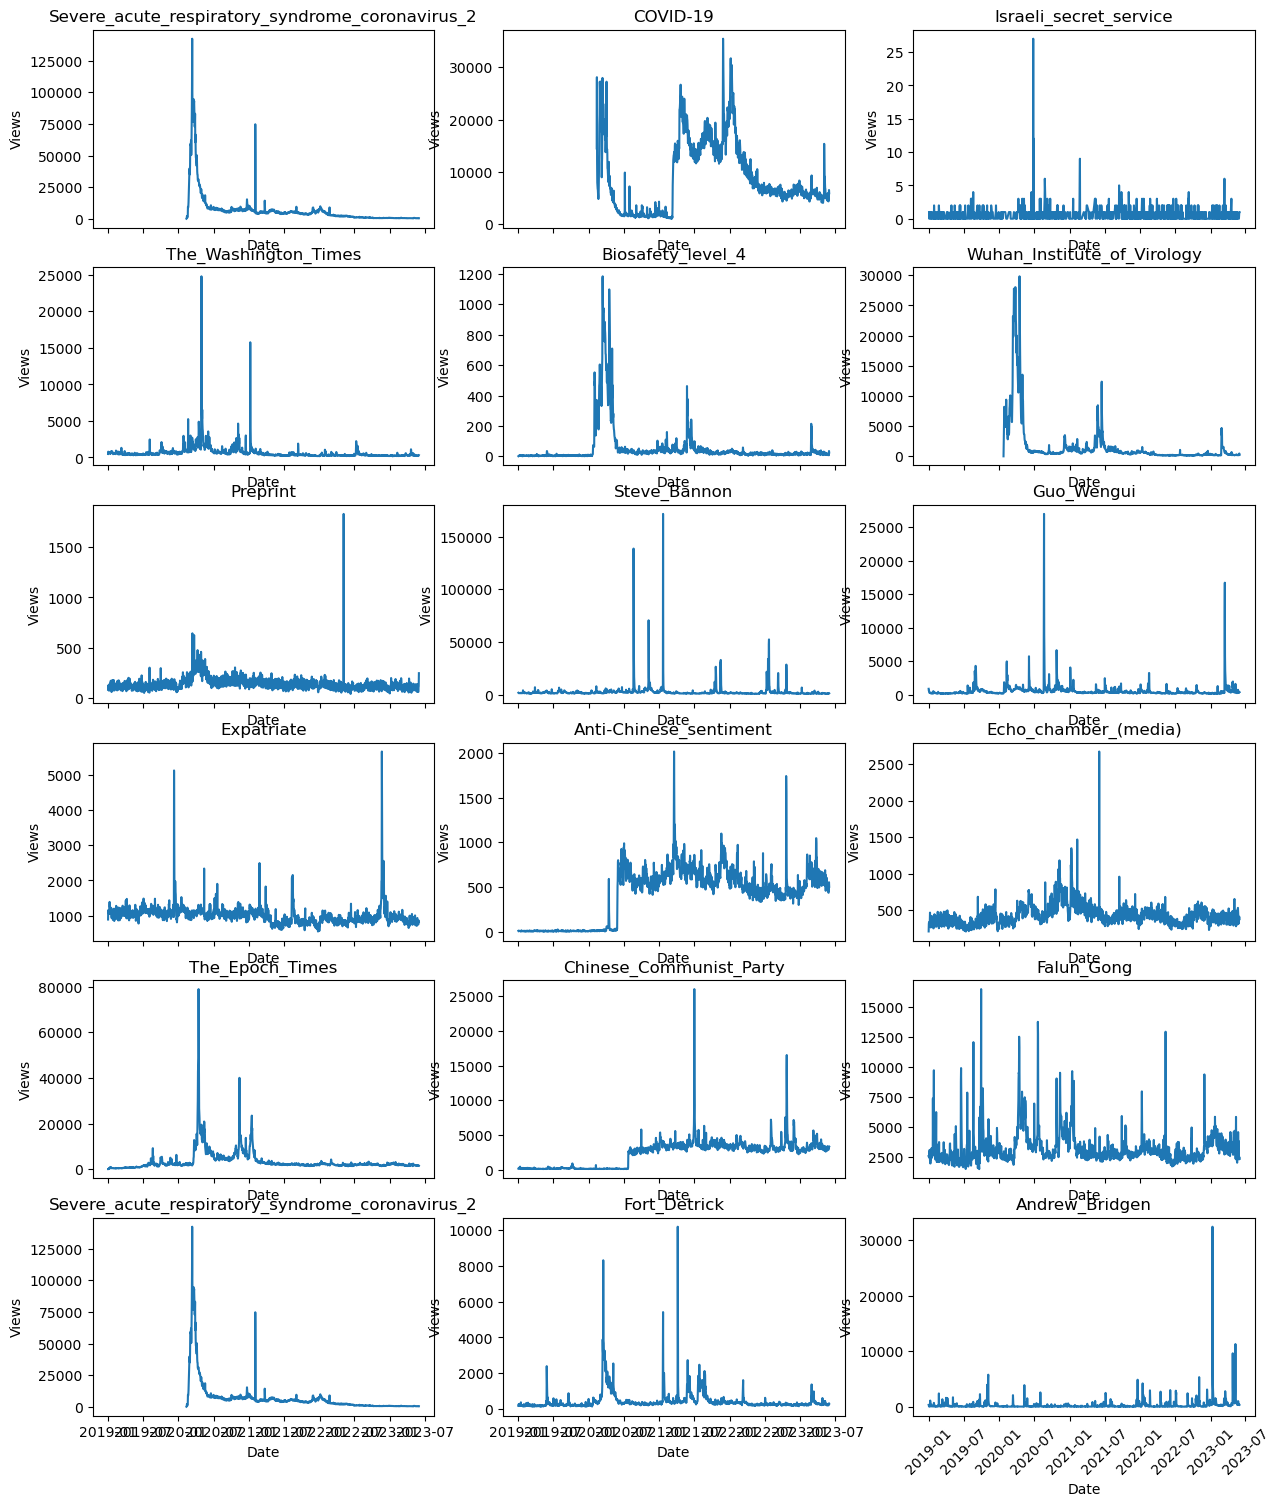

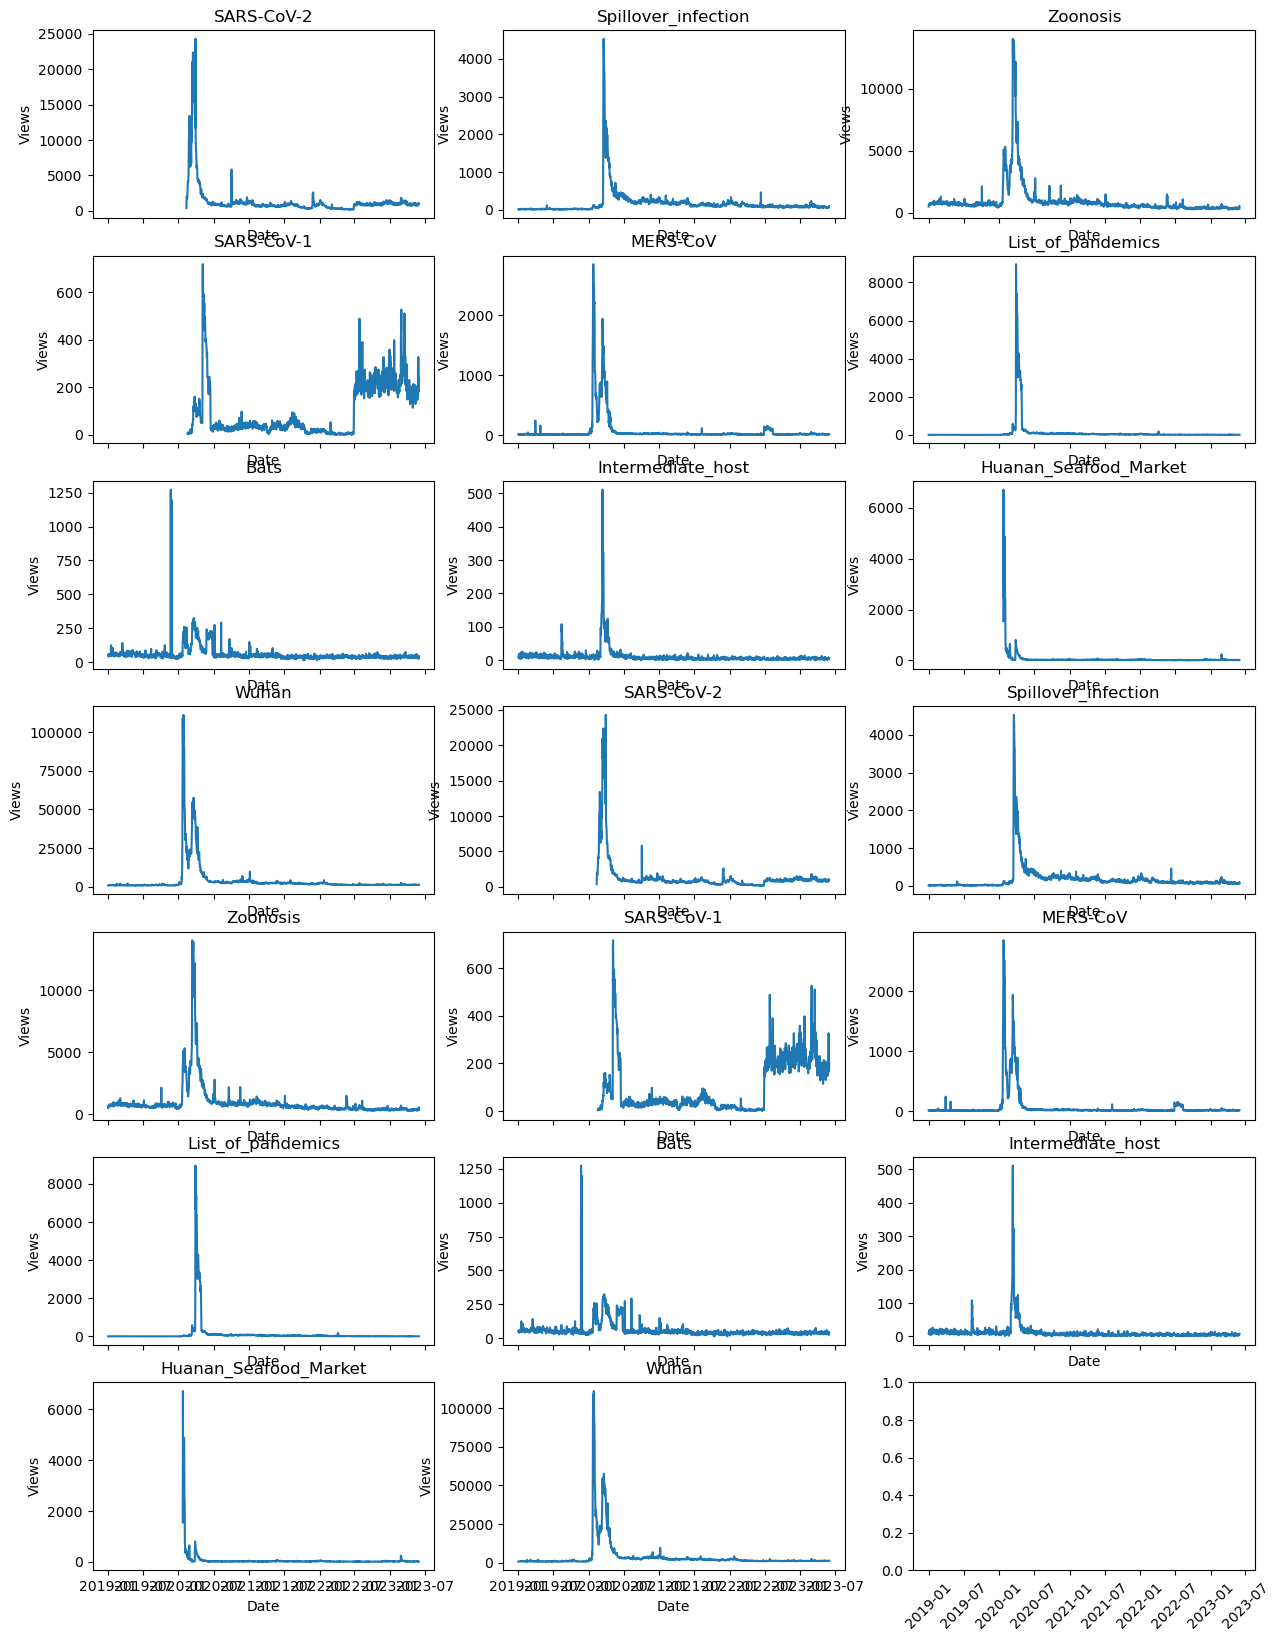

In [262]:
plotAllInfos(topic, nonefunction)

In [326]:
def getViewsNormalizedTotal(topic, function):
    dftemp = topic.dfViewFinal.copy()

    columns = ["timestamp", "viewNormalized"]
    newdf = pd.DataFrame(columns=columns)

    for i in range(len(topic.dfViewFinal)):
        dftemp[i]["viewNormalized"] = function(topic.dfViewFinal[i]['views'])
        newdf = pd.concat([newdf, dftemp[i][["timestamp", "viewNormalized"]]], ignore_index=True)

    newdf = newdf.groupby("timestamp").sum()

    return newdf
    

C:\Users\pablo\AppData\Local\Temp\ipykernel_8036\3824554915.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  newdf = pd.concat([newdf, dftemp[i][["timestamp", "viewNormalized"]]], ignore_index=True)


<Axes: xlabel='timestamp'>

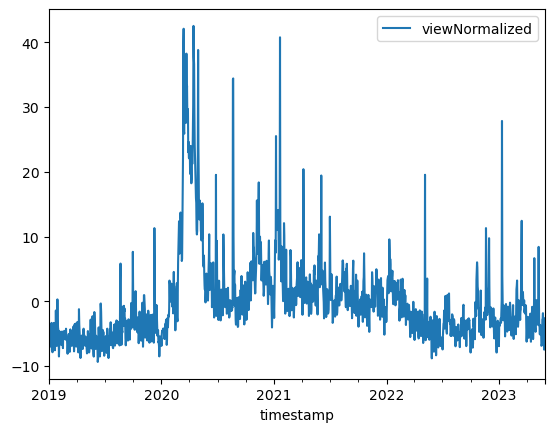

In [329]:
getViewsNormalizedTotal(topic, standarization).plot()